In [1]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.python.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import numpy as np



import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
mols = list()
smiles = [i.strip('\n') for i in open('larger_dataset.smi', 'r').readlines()]
for smi in smiles:
    mols.append(Chem.MolFromSmiles(smi))

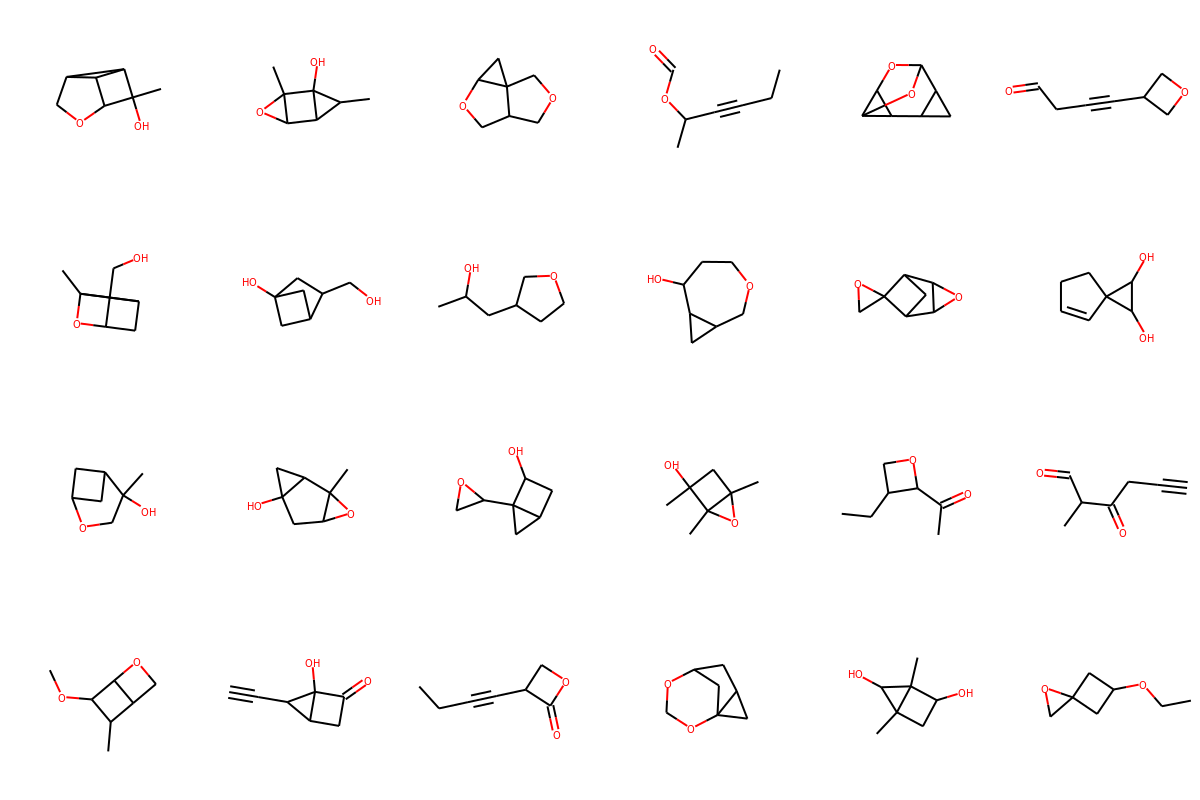

In [3]:
Draw.MolsToGridImage(np.random.choice(np.array(mols), 24), molsPerRow=6)


In [4]:

def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None
    
def permute_edm(edm, atom_identities, num_permutes=1000):
    edm= squareform(edm)
    idx = np.arange(9)
    edm_list = list()
    atom_list = list()
    
    for _ in range(num_permutes):
        np.random.shuffle(idx)
        edm_copy = edm[idx][:,idx]
        edm_list.append(squareform(edm_copy))
        atom_list.append(atom_identities[idx])
    return edm_list, atom_list

In [5]:
#edms = list()
#atomidx = list()
#for count, m in enumerate(np.random.choice(np.array(mols), 2000)):
#    print(count, end='\r')
#    points = getEDM(m)
#    if points is None:
#        None
#    else:
#        edm = pdist(points)
#        atoms = np.clip(np.array([i.GetAtomicNum() for i in m.GetAtoms()])-7, 0, 1)
#        el, al = permute_edm(edm, atoms, num_permutes=10)
#        for e, a in zip(el, al):
#            edms.append(e)
#            atomidx.append(a)

In [6]:
amats = list()
atomidx = list()
for count, m in enumerate(np.random.choice(np.array(mols), 2000)):
    print(count, end='\r')
    atoms = np.clip(np.array([i.GetAtomicNum() for i in m.GetAtoms()])-7, 0, 1)
    sort_indices = np.argsort(np.array(atoms, dtype=bool))
    amat = Chem.GetAdjacencyMatrix(m)
    amats.append(amat[sort_indices][:,sort_indices])
    

In [7]:
data = np.array([squareform(a) for a in amats])

In [8]:
#import copy
#edms = np.array(edms)
#data = copy.copy(edms)
#
#data = np.log10(edms)
##data_mean = np.mean(data)
#data = data- np.mean(data)
#maximum = np.max(np.abs(data))
#print('max is:', maximum)
#print('min is:', np.min(data))
#
###Stacking EDMs onto atom identities:
#
#data = np.hstack([data, np.array(atomidx)])

# Simple WGAN:

In [9]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.initializers import RandomNormal

In [26]:



#https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
    
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
 
    # clip model weights to hypercube
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)
 
    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}
    

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = ClipConstraint(0.01)
    # define model
    model = Sequential()
    num=1024
    model.add(Dense(num, kernel_initializer=init,
                            kernel_constraint=const,
                   input_dim=36))#, activation=LeakyReLU(alpha=0.2)))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
            
    ##Learning layers:
    for _ in range(3):
            model.add(Dense(num, kernel_initializer=init,
                            kernel_constraint=const))#, activation=LeakyReLU(alpha=0.2)))
            #model.add(BatchNormalization())
            model.add(LeakyReLU(alpha=0.2))

    #model.add(Dense(32, kernel_initializer=init,
    #                        kernel_constraint=const, activation=LeakyReLU(alpha=0.2)))
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.2))
    
    # scoring, linear activation
    model.add(Dense(1, activation='linear'))
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
                      
    return model


def define_generator(latent_dim=100):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()

    num=1024
    model.add(Dense(num, kernel_initializer=init, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    for _ in range(3):
        model.add(Dense(num, kernel_initializer=init))#, activation=LeakyReLU(alpha=0.2)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
    model.add(Dense(128, kernel_initializer=init))#, activation=LeakyReLU(alpha=0.2)))
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(36, activation='sigmoid'))
    return model


def define_gan(generator, critic):
    # make weights in the critic not trainable
    critic.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the critic
    model.add(critic)
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model


def generate_real_samples(data, size):
    # select all of the examples for a given class
    idx = np.random.randint(0, data.shape[0], size)
    X = data[idx]
    labels = -1*np.ones(size)
    return X, labels

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = np.ones((n_samples, 1))
    return X, y

def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.close()
    
                  
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=512, n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            c1_tmp.append(c_loss1)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            c2_tmp.append(c_loss2)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = -np.ones((n_batch, 1))
        # update the generator via the critic's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)

        # summarize loss on this batch
        if (i+10) % bat_per_epo/10 == 0:
            c1_hist.append(np.mean(c1_tmp))
            c2_hist.append(np.mean(c2_tmp))
            g_hist.append(g_loss)
            print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
        if (i+100) % bat_per_epo/100 == 0:
            plot_history(c1_hist, c2_hist, g_hist)
            
        # evaluate the model performance every 'epoch'
    # line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)

In [27]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

>3, c1=-0.021, c2=-0.005 g=0.013
>6, c1=-0.323, c2=-0.172 g=0.037
>9, c1=-1.470, c2=-0.944 g=-0.201
>12, c1=-3.924, c2=-2.869 g=-1.923
>15, c1=-8.151, c2=-6.475 g=-6.378
>18, c1=-14.490, c2=-12.232 g=-13.110
>21, c1=-23.496, c2=-20.566 g=-24.175
>24, c1=-35.423, c2=-31.954 g=-37.721
>27, c1=-50.396, c2=-46.526 g=-58.591
>30, c1=-67.871, c2=-64.270 g=-80.585
>33, c1=-88.900, c2=-85.986 g=-109.446
>36, c1=-112.517, c2=-110.769 g=-142.717
>39, c1=-138.267, c2=-138.785 g=-179.998
>42, c1=-164.071, c2=-168.742 g=-221.043
>45, c1=-193.473, c2=-198.962 g=-264.837
>48, c1=-224.233, c2=-229.450 g=-310.349
>51, c1=-254.411, c2=-260.213 g=-356.466
>54, c1=-275.729, c2=-288.417 g=-396.458
>57, c1=-286.237, c2=-310.263 g=-419.789
>60, c1=-290.355, c2=-325.914 g=-437.300
>63, c1=-289.827, c2=-336.596 g=-453.067
>66, c1=-284.384, c2=-343.034 g=-468.146
>69, c1=-282.304, c2=-347.161 g=-480.496
>72, c1=-274.325, c2=-347.250 g=-492.415
>75, c1=-268.818, c2=-343.041 g=-502.285
>78, c1=-253.135, c2=-331.0

>591, c1=-21.695, c2=10.335 g=-38.474
>594, c1=-25.311, c2=7.216 g=-63.198
>597, c1=-33.364, c2=7.266 g=-101.643
>600, c1=-44.208, c2=18.847 g=-151.652
>603, c1=-51.688, c2=55.919 g=-151.876
>606, c1=-53.009, c2=53.853 g=-136.465
>609, c1=-54.397, c2=51.728 g=-113.629
>612, c1=-57.197, c2=39.925 g=-101.446
>615, c1=-61.142, c2=33.438 g=-89.311
>618, c1=-64.246, c2=24.931 g=-84.333
>621, c1=-70.078, c2=12.597 g=-82.584
>624, c1=-78.478, c2=6.527 g=-84.863
>627, c1=-89.693, c2=7.576 g=-92.142
>630, c1=-105.470, c2=-3.516 g=-107.864
>633, c1=-119.660, c2=4.946 g=-115.780
>636, c1=-120.165, c2=-49.866 g=-95.425
>639, c1=-109.459, c2=-130.889 g=-61.877
>642, c1=-87.775, c2=-200.098 g=-36.842
>645, c1=-30.203, c2=-347.544 g=5.401
>648, c1=20.739, c2=-434.133 g=59.067
>651, c1=73.701, c2=-482.999 g=104.629
>654, c1=93.518, c2=-513.921 g=112.502
>657, c1=129.647, c2=-533.480 g=108.758
>660, c1=133.129, c2=-587.630 g=109.848
>663, c1=134.152, c2=-533.851 g=101.138
>666, c1=131.003, c2=-570.682 

>1197, c1=-139.332, c2=135.906 g=-139.723
>1200, c1=-133.615, c2=133.671 g=-142.796
>1203, c1=-129.508, c2=125.403 g=-139.712
>1206, c1=-123.960, c2=122.976 g=-138.302
>1209, c1=-126.115, c2=124.493 g=-138.513
>1212, c1=-124.397, c2=123.771 g=-137.666
>1215, c1=-123.596, c2=123.447 g=-139.038
>1218, c1=-122.822, c2=126.537 g=-144.244
>1221, c1=-123.581, c2=130.700 g=-145.812
>1224, c1=-124.350, c2=133.750 g=-141.180
>1227, c1=-123.609, c2=127.685 g=-139.880
>1230, c1=-122.298, c2=126.002 g=-136.252
>1233, c1=-119.703, c2=123.921 g=-131.170
>1236, c1=-119.261, c2=120.837 g=-126.352
>1239, c1=-116.615, c2=114.602 g=-124.977
>1242, c1=-116.230, c2=109.945 g=-122.852
>1245, c1=-116.605, c2=115.509 g=-119.719
>1248, c1=-115.164, c2=112.931 g=-121.853
>1251, c1=-113.424, c2=110.513 g=-120.453
>1254, c1=-112.822, c2=115.017 g=-123.380
>1257, c1=-110.824, c2=112.428 g=-123.805
>1260, c1=-112.681, c2=116.863 g=-128.385
>1263, c1=-113.081, c2=123.854 g=-130.890
>1266, c1=-115.590, c2=126.029 g=-

>1839, c1=-8.729, c2=9.011 g=-8.586
>1842, c1=-8.656, c2=8.896 g=-8.477
>1845, c1=-8.772, c2=8.971 g=-8.608
>1848, c1=-8.972, c2=9.252 g=-8.807
>1851, c1=-8.714, c2=9.155 g=-8.343
>1854, c1=-8.014, c2=8.436 g=-8.081
>1857, c1=-7.851, c2=8.160 g=-7.807
>1860, c1=-7.710, c2=7.937 g=-7.672
>1863, c1=-7.790, c2=7.973 g=-7.670
>1866, c1=-8.006, c2=8.166 g=-7.914
>1869, c1=-8.270, c2=8.347 g=-8.014
>1872, c1=-8.384, c2=8.431 g=-8.183
>1875, c1=-8.440, c2=8.510 g=-8.346
>1878, c1=-8.473, c2=8.633 g=-8.527
>1881, c1=-8.512, c2=8.621 g=-8.424
>1884, c1=-8.658, c2=8.647 g=-8.552
>1887, c1=-8.947, c2=8.731 g=-8.614
>1890, c1=-9.545, c2=8.723 g=-8.284
>1893, c1=-10.074, c2=9.125 g=-8.201
>1896, c1=-9.648, c2=9.930 g=-9.232
>1899, c1=-9.296, c2=9.254 g=-10.189
>1902, c1=-9.654, c2=9.535 g=-10.113
>1905, c1=-10.163, c2=10.013 g=-10.518
>1908, c1=-10.790, c2=10.650 g=-11.498
>1911, c1=-11.880, c2=11.629 g=-12.170
>1914, c1=-12.762, c2=12.652 g=-13.125
>1917, c1=-13.371, c2=13.499 g=-13.968
>1920, c1=

>2475, c1=-33.671, c2=30.624 g=-32.562
>2478, c1=-34.421, c2=30.764 g=-32.726
>2481, c1=-34.394, c2=31.541 g=-34.985
>2484, c1=-33.939, c2=32.059 g=-33.284
>2487, c1=-33.905, c2=30.456 g=-30.229
>2490, c1=-33.357, c2=30.170 g=-28.959
>2493, c1=-31.411, c2=30.865 g=-33.331
>2496, c1=-31.185, c2=30.490 g=-33.492
>2499, c1=-29.959, c2=28.934 g=-32.865
>2502, c1=-28.806, c2=27.588 g=-32.467
>2505, c1=-28.037, c2=26.926 g=-32.198
>2508, c1=-27.122, c2=26.728 g=-32.974
>2511, c1=-27.929, c2=28.333 g=-35.247
>2514, c1=-27.632, c2=27.029 g=-35.170
>2517, c1=-27.878, c2=26.048 g=-34.366
>2520, c1=-27.879, c2=25.457 g=-33.434
>2523, c1=-27.368, c2=25.324 g=-32.911
>2526, c1=-27.005, c2=25.280 g=-31.127
>2529, c1=-27.600, c2=27.013 g=-28.292
>2532, c1=-28.804, c2=28.330 g=-26.185
>2535, c1=-28.845, c2=29.048 g=-26.533
>2538, c1=-27.880, c2=29.352 g=-26.827
>2541, c1=-27.162, c2=28.428 g=-27.047
>2544, c1=-26.624, c2=27.018 g=-25.696
>2547, c1=-27.236, c2=25.409 g=-24.736
>2550, c1=-26.588, c2=25.

>3117, c1=-100.895, c2=-0.317 g=-17.707
>3120, c1=-91.787, c2=-30.881 g=16.360
>3123, c1=-92.427, c2=-39.125 g=35.715
>3126, c1=-96.985, c2=-50.577 g=38.087
>3129, c1=-67.454, c2=-11.030 g=42.726
>3132, c1=-53.291, c2=-13.491 g=47.558
>3135, c1=-41.049, c2=-40.841 g=65.208
>3138, c1=-46.911, c2=-47.572 g=84.780
>3141, c1=-93.643, c2=-40.975 g=51.168
>3144, c1=-156.881, c2=79.549 g=-86.997
>3147, c1=-176.733, c2=120.509 g=-139.634
>3150, c1=-185.922, c2=117.828 g=-154.163
>3153, c1=-192.740, c2=112.903 g=-173.457
>3156, c1=-137.420, c2=38.869 g=-99.644
>3159, c1=-105.774, c2=-19.380 g=-46.407
>3162, c1=-81.883, c2=-77.160 g=14.148
>3165, c1=-70.567, c2=-38.215 g=-8.655
>3168, c1=-3.765, c2=-71.826 g=69.154
>3171, c1=7.123, c2=-107.495 g=101.394
>3174, c1=-13.959, c2=-91.722 g=94.052
>3177, c1=-68.548, c2=-40.891 g=55.351
>3180, c1=-83.138, c2=4.062 g=8.419
>3183, c1=-80.408, c2=-9.475 g=19.480
>3186, c1=-54.366, c2=-66.171 g=92.989
>3189, c1=-52.746, c2=-10.274 g=27.196
>3192, c1=-113.1

>3738, c1=-135.553, c2=-30.953 g=29.234
>3741, c1=-182.018, c2=72.264 g=-61.910
>3744, c1=-194.325, c2=95.029 g=-85.752
>3747, c1=-117.034, c2=-57.162 g=32.492
>3750, c1=-120.624, c2=-57.219 g=51.539
>3753, c1=-139.438, c2=-47.343 g=70.917
>3756, c1=-155.204, c2=-43.778 g=111.631
>3759, c1=-173.616, c2=20.772 g=64.151
>3762, c1=-239.417, c2=80.613 g=3.646
>3765, c1=-308.495, c2=145.214 g=-88.804
>3768, c1=-316.235, c2=125.943 g=-87.488
>3771, c1=-297.284, c2=82.087 g=-14.598
>3774, c1=-234.749, c2=-58.768 g=92.408
>3777, c1=-188.923, c2=-75.166 g=79.617
>3780, c1=-168.140, c2=-58.893 g=32.185
>3783, c1=-160.788, c2=6.876 g=-90.189
>3786, c1=-118.449, c2=-15.489 g=-92.183
>3789, c1=-102.861, c2=-48.742 g=-170.829
>3792, c1=-70.746, c2=-125.301 g=-137.682
>3795, c1=-91.865, c2=-117.873 g=-221.917
>3798, c1=-58.310, c2=-141.922 g=-249.584
>3801, c1=-39.158, c2=-162.716 g=-288.372
>3804, c1=-88.900, c2=-33.840 g=-275.396
>3807, c1=-117.703, c2=-10.243 g=-276.583
>3810, c1=-134.211, c2=8.13

>4347, c1=-119.786, c2=-92.237 g=96.744
>4350, c1=-192.242, c2=-42.548 g=61.890
>4353, c1=-187.035, c2=-88.848 g=100.565
>4356, c1=-217.932, c2=-74.928 g=32.508
>4359, c1=-236.554, c2=29.649 g=-102.943
>4362, c1=-230.999, c2=41.792 g=-126.522
>4365, c1=-220.688, c2=51.579 g=-140.878
>4368, c1=-245.685, c2=41.063 g=-128.027
>4371, c1=-236.396, c2=-19.209 g=-99.523
>4374, c1=-244.779, c2=-73.910 g=-62.729
>4377, c1=-219.621, c2=-42.615 g=-20.403
>4380, c1=-224.062, c2=-49.992 g=-44.481
>4383, c1=-226.270, c2=-46.434 g=-53.958
>4386, c1=-243.608, c2=-82.338 g=-30.079
>4389, c1=-216.929, c2=-54.777 g=-54.322
>4392, c1=-196.117, c2=36.752 g=-80.291
>4395, c1=-143.836, c2=-6.794 g=-27.444
>4398, c1=-69.636, c2=-71.886 g=-31.061
>4401, c1=-54.751, c2=-84.357 g=25.769
>4404, c1=-142.420, c2=-55.768 g=-4.748
>4407, c1=-128.950, c2=-17.260 g=24.113
>4410, c1=-134.187, c2=-101.275 g=62.388
>4413, c1=-166.977, c2=-153.192 g=113.233
>4416, c1=-190.283, c2=-66.484 g=87.218
>4419, c1=-252.516, c2=-63

>4947, c1=-277.529, c2=-62.409 g=82.166
>4950, c1=-297.856, c2=-115.262 g=141.271
>4953, c1=-326.099, c2=-133.071 g=172.093
>4956, c1=-312.360, c2=75.872 g=102.618
>4959, c1=-435.246, c2=330.661 g=-195.049
>4962, c1=-379.484, c2=101.574 g=-13.953
>4965, c1=-259.305, c2=-194.500 g=157.077
>4968, c1=-249.760, c2=-198.996 g=193.603
>4971, c1=-276.955, c2=-159.926 g=176.618
>4974, c1=-313.832, c2=31.690 g=-31.254
>4977, c1=-314.404, c2=-6.248 g=-48.520
>4980, c1=-272.771, c2=-159.105 g=-92.209
>4983, c1=-215.469, c2=-229.663 g=81.878
>4986, c1=-184.705, c2=-246.772 g=235.875
>4989, c1=-290.333, c2=-234.013 g=191.379
>4992, c1=-402.171, c2=-117.919 g=129.434
>4995, c1=-404.064, c2=-72.762 g=94.584
>4998, c1=-307.867, c2=-122.592 g=97.826
>5001, c1=-321.721, c2=5.681 g=-122.278
>5004, c1=-276.625, c2=-61.291 g=-70.309
>5007, c1=-256.825, c2=-53.657 g=-70.075
>5010, c1=-255.250, c2=-85.290 g=-143.120
>5013, c1=-318.725, c2=-81.333 g=-214.745
>5016, c1=-367.620, c2=-92.606 g=-254.254
>5019, c1

>5541, c1=-121.477, c2=-298.537 g=-87.713
>5544, c1=-57.922, c2=-254.510 g=-63.976
>5547, c1=-85.720, c2=-292.907 g=-55.309
>5550, c1=-172.346, c2=-249.607 g=3.437
>5553, c1=-309.157, c2=-139.406 g=-8.884
>5556, c1=-312.927, c2=-42.163 g=58.247
>5559, c1=-283.976, c2=-172.438 g=154.194
>5562, c1=-327.991, c2=-221.314 g=137.846
>5565, c1=-330.183, c2=190.872 g=-336.553
>5568, c1=-426.173, c2=438.362 g=-427.115
>5571, c1=-415.754, c2=285.942 g=-124.585
>5574, c1=-324.199, c2=-216.446 g=249.768
>5577, c1=-358.695, c2=-277.680 g=198.096
>5580, c1=-425.845, c2=-125.298 g=19.389
>5583, c1=-410.959, c2=-211.391 g=-161.541
>5586, c1=-479.086, c2=-208.516 g=-305.500
>5589, c1=-426.920, c2=-197.757 g=-377.932
>5592, c1=-319.743, c2=-126.929 g=-326.386
>5595, c1=-263.759, c2=-120.034 g=-176.242
>5598, c1=-289.477, c2=-289.215 g=-17.354
>5601, c1=-388.501, c2=-244.908 g=-119.518
>5604, c1=-460.560, c2=-209.245 g=-238.912
>5607, c1=-472.071, c2=-158.818 g=-390.314
>5610, c1=-348.419, c2=-139.522 g=

>6126, c1=-328.934, c2=-151.206 g=-573.440
>6129, c1=-391.204, c2=-112.777 g=-690.479
>6132, c1=-483.952, c2=-190.920 g=-559.620
>6135, c1=-510.657, c2=50.185 g=-424.155
>6138, c1=-496.195, c2=-30.382 g=-305.629
>6141, c1=-500.546, c2=-99.624 g=-301.716
>6144, c1=-439.703, c2=-185.081 g=-327.648
>6147, c1=-446.389, c2=30.288 g=-402.193
>6150, c1=-532.048, c2=51.665 g=-383.454
>6153, c1=-616.571, c2=-134.282 g=-364.101
>6156, c1=-691.576, c2=-93.767 g=-403.543
>6159, c1=-705.196, c2=-124.101 g=-498.665
>6162, c1=-732.190, c2=37.540 g=-615.393
>6165, c1=-737.035, c2=120.989 g=-618.457
>6168, c1=-733.041, c2=163.628 g=-630.492
>6171, c1=-850.841, c2=193.411 g=-826.557
>6174, c1=-962.800, c2=243.706 g=-957.807
>6177, c1=-989.211, c2=162.086 g=-989.157
>6180, c1=-1028.549, c2=259.018 g=-1003.115
>6183, c1=-1031.403, c2=164.571 g=-886.662
>6186, c1=-946.823, c2=270.296 g=-1003.507
>6189, c1=-854.409, c2=355.023 g=-982.397
>6192, c1=-784.132, c2=218.678 g=-863.571
>6195, c1=-743.242, c2=46.63

>6705, c1=-668.921, c2=426.340 g=-2030.181
>6708, c1=-788.624, c2=374.291 g=-1772.097
>6711, c1=-837.105, c2=309.212 g=-1577.416
>6714, c1=-919.327, c2=183.734 g=-1498.763
>6717, c1=-915.193, c2=253.431 g=-1313.678
>6720, c1=-864.524, c2=103.780 g=-1179.672
>6723, c1=-882.653, c2=183.233 g=-1012.908
>6726, c1=-923.977, c2=14.418 g=-873.352
>6729, c1=-849.727, c2=-189.132 g=-776.054
>6732, c1=-668.218, c2=-183.636 g=-582.120
>6735, c1=-596.463, c2=-311.097 g=-539.624
>6738, c1=-533.127, c2=-240.292 g=-539.044
>6741, c1=-522.649, c2=91.991 g=-587.619
>6744, c1=-607.151, c2=55.468 g=-547.752
>6747, c1=-703.228, c2=6.343 g=-387.696
>6750, c1=-764.095, c2=103.485 g=-400.008
>6753, c1=-706.503, c2=-44.547 g=-299.766
>6756, c1=-529.232, c2=-239.153 g=-188.546
>6759, c1=-463.187, c2=-272.285 g=-263.757
>6762, c1=-578.914, c2=-255.135 g=-756.093
>6765, c1=-683.636, c2=-232.256 g=-1301.025
>6768, c1=-797.524, c2=-394.549 g=-1736.853
>6771, c1=-723.392, c2=-272.128 g=-1834.954
>6774, c1=-638.891,

>7281, c1=-931.011, c2=111.544 g=-1229.315
>7284, c1=-1022.810, c2=340.951 g=-1585.205
>7287, c1=-996.286, c2=49.309 g=-1686.948
>7290, c1=-618.230, c2=-109.677 g=-1328.299
>7293, c1=-336.982, c2=-482.087 g=-981.727
>7296, c1=-203.717, c2=-527.664 g=-759.619
>7299, c1=-104.072, c2=-537.533 g=-776.001
>7302, c1=-208.453, c2=-570.232 g=-782.492
>7305, c1=-255.478, c2=-653.278 g=-651.181
>7308, c1=-331.119, c2=-702.922 g=-792.816
>7311, c1=-507.992, c2=-421.185 g=-1111.529
>7314, c1=-568.764, c2=-374.076 g=-1369.825
>7317, c1=-516.459, c2=-533.396 g=-1844.722
>7320, c1=-479.955, c2=-644.559 g=-2141.374
>7323, c1=-461.875, c2=-620.336 g=-2268.952
>7326, c1=-460.285, c2=-477.060 g=-2042.766
>7329, c1=-252.632, c2=-271.949 g=-1689.910
>7332, c1=-365.956, c2=-399.223 g=-1284.274
>7335, c1=-630.967, c2=-460.541 g=-830.249
>7338, c1=-779.675, c2=-556.971 g=-684.910
>7341, c1=-928.516, c2=-262.586 g=-1151.850
>7344, c1=-1039.991, c2=-252.571 g=-1377.414
>7347, c1=-1068.879, c2=-104.421 g=-1508.3

>7848, c1=-1364.677, c2=-157.363 g=-1497.067
>7851, c1=-1393.257, c2=-111.038 g=-1592.579
>7854, c1=-1259.963, c2=-33.563 g=-1600.766
>7857, c1=-1281.340, c2=-7.718 g=-1599.356
>7860, c1=-1330.835, c2=68.650 g=-1540.965
>7863, c1=-1412.464, c2=12.066 g=-1726.703
>7866, c1=-1540.627, c2=217.650 g=-1586.199
>7869, c1=-1520.568, c2=-39.371 g=-1292.071
>7872, c1=-1423.496, c2=-132.487 g=-1493.754
>7875, c1=-1286.695, c2=-15.696 g=-1500.195
>7878, c1=-1063.373, c2=-205.713 g=-1279.392
>7881, c1=-857.065, c2=-136.599 g=-961.599
>7884, c1=-824.530, c2=-369.712 g=-1041.395
>7887, c1=-759.521, c2=-201.579 g=-1195.637
>7890, c1=-722.053, c2=-499.206 g=-1056.255
>7893, c1=-802.564, c2=-344.520 g=-802.972
>7896, c1=-851.875, c2=-23.253 g=-1015.806
>7899, c1=-915.239, c2=-124.579 g=-1358.934
>7902, c1=-818.603, c2=136.133 g=-1332.571
>7905, c1=-991.395, c2=-356.206 g=-1519.624
>7908, c1=-1207.344, c2=-95.540 g=-1103.123
>7911, c1=-1069.432, c2=-229.580 g=-920.998
>7914, c1=-868.869, c2=120.338 g=-8

>8415, c1=-889.069, c2=-619.282 g=-982.729
>8418, c1=-916.928, c2=-823.106 g=-1215.572
>8421, c1=-743.003, c2=-729.173 g=-1548.786
>8424, c1=-701.761, c2=-392.520 g=-2344.096
>8427, c1=-809.130, c2=-364.432 g=-2649.222
>8430, c1=-854.764, c2=-637.238 g=-2603.967
>8433, c1=-710.930, c2=-902.521 g=-2489.701
>8436, c1=-620.118, c2=-521.401 g=-2176.983
>8439, c1=-601.190, c2=-442.936 g=-1620.108
>8442, c1=-942.030, c2=-408.870 g=-971.469
>8445, c1=-1117.082, c2=-10.231 g=-1135.810
>8448, c1=-1219.275, c2=147.126 g=-1085.587
>8451, c1=-1156.775, c2=-136.088 g=-962.543
>8454, c1=-1236.003, c2=588.545 g=-1319.423
>8457, c1=-1393.323, c2=32.703 g=-1074.823
>8460, c1=-1453.684, c2=-328.926 g=-1670.381
>8463, c1=-1637.830, c2=-155.697 g=-2095.729
>8466, c1=-1716.387, c2=29.103 g=-2186.058
>8469, c1=-1805.379, c2=198.269 g=-2217.642
>8472, c1=-1849.850, c2=53.634 g=-2237.580
>8475, c1=-1954.838, c2=297.488 g=-2394.300
>8478, c1=-2098.314, c2=545.695 g=-2560.823
>8481, c1=-2082.845, c2=579.986 g=-

>8979, c1=-860.343, c2=-102.555 g=-3240.313
>8982, c1=-285.166, c2=-447.493 g=-2565.998
>8985, c1=-221.732, c2=-424.410 g=-1803.386
>8988, c1=-523.416, c2=-376.120 g=-1218.512
>8991, c1=-788.076, c2=104.114 g=-1186.495
>8994, c1=-1079.076, c2=124.215 g=-1026.032
>8997, c1=-1403.192, c2=130.624 g=-1393.774
>9000, c1=-1661.859, c2=32.579 g=-2018.717
>9003, c1=-1948.756, c2=-108.838 g=-2523.926
>9006, c1=-2184.056, c2=376.623 g=-2945.558
>9009, c1=-2386.930, c2=623.565 g=-3078.356
>9012, c1=-2373.606, c2=321.155 g=-3054.738
>9015, c1=-2451.507, c2=511.752 g=-3344.003
>9018, c1=-2532.230, c2=767.657 g=-3295.136
>9021, c1=-2349.733, c2=603.527 g=-2956.729
>9024, c1=-2406.801, c2=486.685 g=-2829.293
>9027, c1=-2464.785, c2=135.451 g=-2718.641
>9030, c1=-2597.491, c2=505.625 g=-2981.913
>9033, c1=-2705.549, c2=651.139 g=-2937.656
>9036, c1=-2697.201, c2=840.358 g=-2870.515
>9039, c1=-2516.695, c2=974.846 g=-2911.062
>9042, c1=-2456.245, c2=942.743 g=-2811.943
>9045, c1=-2382.344, c2=1003.999 

>9540, c1=-1000.981, c2=301.632 g=-1667.010
>9543, c1=-1086.732, c2=282.971 g=-1380.604
>9546, c1=-1387.827, c2=22.847 g=-1340.360
>9549, c1=-1399.907, c2=-90.405 g=-1657.048
>9552, c1=-1333.248, c2=-454.249 g=-1739.125
>9555, c1=-1142.187, c2=-759.405 g=-3035.181
>9558, c1=-1017.701, c2=-595.592 g=-4444.722
>9561, c1=-1002.538, c2=-721.987 g=-5170.791
>9564, c1=-924.480, c2=-681.672 g=-4696.989
>9567, c1=-1034.583, c2=-555.111 g=-4123.714
>9570, c1=-1417.265, c2=-509.104 g=-3300.111
>9573, c1=-1679.683, c2=-204.173 g=-2355.654
>9576, c1=-1802.537, c2=891.936 g=-1345.202
>9579, c1=-1926.011, c2=1243.525 g=-1457.832
>9582, c1=-1849.107, c2=624.181 g=-1818.101
>9585, c1=-1684.004, c2=564.723 g=-2128.323
>9588, c1=-1640.491, c2=-54.131 g=-1943.739
>9591, c1=-1754.541, c2=-301.694 g=-1940.744
>9594, c1=-1781.229, c2=277.147 g=-2054.419
>9597, c1=-1902.732, c2=805.282 g=-2235.632
>9600, c1=-2099.304, c2=915.456 g=-2259.467
>9603, c1=-2094.240, c2=686.903 g=-2239.742
>9606, c1=-1833.238, c2=

>10098, c1=-2079.948, c2=538.097 g=-2504.418
>10101, c1=-2023.827, c2=304.886 g=-2460.963
>10104, c1=-1747.452, c2=485.413 g=-2148.275
>10107, c1=-1839.167, c2=784.858 g=-2471.282
>10110, c1=-1887.370, c2=851.725 g=-2655.526
>10113, c1=-1915.836, c2=767.891 g=-2478.941
>10116, c1=-1944.461, c2=667.600 g=-2075.514
>10119, c1=-1907.022, c2=504.913 g=-1775.767
>10122, c1=-1915.437, c2=770.395 g=-1732.105
>10125, c1=-1864.145, c2=732.579 g=-2028.826
>10128, c1=-1777.324, c2=732.825 g=-1923.291
>10131, c1=-1500.010, c2=274.228 g=-1516.481
>10134, c1=-1558.610, c2=252.158 g=-1340.135
>10137, c1=-1603.358, c2=401.103 g=-1293.867
>10140, c1=-1546.402, c2=300.166 g=-1577.444
>10143, c1=-1569.615, c2=315.293 g=-3028.412
>10146, c1=-1433.125, c2=325.796 g=-3270.412
>10149, c1=-910.876, c2=-424.736 g=-2490.105
>10152, c1=-778.728, c2=-636.258 g=-1888.857
>10155, c1=-949.027, c2=-850.003 g=-1325.053
>10158, c1=-1120.216, c2=-991.575 g=-2028.127
>10161, c1=-1165.317, c2=-354.087 g=-2210.900
>10164, 

>10644, c1=-91.285, c2=-1427.012 g=-1187.037
>10647, c1=-519.297, c2=-1325.552 g=-2220.732
>10650, c1=-576.911, c2=-500.162 g=-2299.530
>10653, c1=-313.895, c2=-449.973 g=-1929.367
>10656, c1=-108.936, c2=-944.608 g=-1774.953
>10659, c1=-218.799, c2=-951.490 g=-1511.148
>10662, c1=-534.176, c2=-853.862 g=-1624.386
>10665, c1=-775.962, c2=-889.753 g=-1577.860
>10668, c1=-1009.642, c2=-834.913 g=-1152.832
>10671, c1=-1147.802, c2=-83.201 g=-1417.651
>10674, c1=-1228.752, c2=136.390 g=-1224.790
>10677, c1=-1194.998, c2=-621.418 g=-425.748
>10680, c1=-1409.162, c2=-177.404 g=-601.247
>10683, c1=-1589.293, c2=15.206 g=-557.314
>10686, c1=-1639.201, c2=173.722 g=-931.467
>10689, c1=-1627.460, c2=37.801 g=-1555.565
>10692, c1=-1735.823, c2=-0.614 g=-1916.617
>10695, c1=-1709.489, c2=-59.590 g=-2222.654
>10698, c1=-1507.522, c2=-68.988 g=-2023.880
>10701, c1=-1324.226, c2=-55.948 g=-2160.917
>10704, c1=-1302.356, c2=162.452 g=-2069.579
>10707, c1=-1127.920, c2=-52.201 g=-1489.305
>10710, c1=-1

>11190, c1=-1971.817, c2=545.251 g=-2971.025
>11193, c1=-1948.433, c2=694.055 g=-3174.317
>11196, c1=-2184.226, c2=764.444 g=-3459.503
>11199, c1=-2093.871, c2=1347.004 g=-3730.679
>11202, c1=-2327.055, c2=1627.529 g=-3507.059
>11205, c1=-2401.899, c2=1496.766 g=-3106.200
>11208, c1=-2493.835, c2=1251.837 g=-2494.962
>11211, c1=-2528.009, c2=1401.239 g=-2355.598
>11214, c1=-2637.444, c2=1603.762 g=-2274.018
>11217, c1=-2526.980, c2=1669.385 g=-2092.499
>11220, c1=-1863.477, c2=966.548 g=-1859.556
>11223, c1=-1597.281, c2=1253.628 g=-1858.921
>11226, c1=-1260.642, c2=874.353 g=-2352.694
>11229, c1=-1392.410, c2=494.015 g=-2484.607
>11232, c1=-1426.784, c2=-114.751 g=-3180.717
>11235, c1=-1419.969, c2=-436.601 g=-3618.742
>11238, c1=-1548.660, c2=-363.079 g=-3752.895
>11241, c1=-1923.515, c2=-496.576 g=-3901.292
>11244, c1=-1875.740, c2=-617.534 g=-3939.243
>11247, c1=-1713.869, c2=210.878 g=-4558.336
>11250, c1=-1475.661, c2=-208.697 g=-4182.191
>11253, c1=-1221.804, c2=-336.511 g=-3542

>11733, c1=-1193.474, c2=-395.001 g=-1201.715
>11736, c1=-1072.092, c2=-168.268 g=-798.658
>11739, c1=-925.571, c2=-469.223 g=-357.061
>11742, c1=-860.205, c2=-613.866 g=-230.927
>11745, c1=-764.527, c2=-1182.509 g=-682.747
>11748, c1=-987.170, c2=-1603.089 g=-1435.834
>11751, c1=-1697.456, c2=406.746 g=-2136.270
>11754, c1=-1909.175, c2=107.365 g=-2114.201
>11757, c1=-1969.771, c2=198.036 g=-2622.181
>11760, c1=-2236.306, c2=1343.072 g=-3372.884
>11763, c1=-2418.037, c2=1391.965 g=-3130.525
>11766, c1=-2075.067, c2=528.786 g=-2599.714
>11769, c1=-1693.282, c2=97.207 g=-2099.830
>11772, c1=-1624.888, c2=-184.907 g=-1364.892
>11775, c1=-1362.819, c2=205.548 g=-1104.412
>11778, c1=-1440.285, c2=-69.148 g=-1028.418
>11781, c1=-1389.685, c2=-560.053 g=-952.118
>11784, c1=-1349.426, c2=-484.531 g=-2049.171
>11787, c1=-1244.778, c2=-355.014 g=-2469.831
>11790, c1=-1173.950, c2=26.535 g=-2836.982
>11793, c1=-1421.180, c2=320.144 g=-3046.315
>11796, c1=-1933.710, c2=796.998 g=-3299.596
>11799,

>12276, c1=-1305.751, c2=-568.286 g=-1455.231
>12279, c1=-1412.352, c2=286.715 g=-1376.313
>12282, c1=-1317.077, c2=-413.521 g=-757.145
>12285, c1=-1092.582, c2=-747.300 g=-628.601
>12288, c1=-896.191, c2=-673.546 g=-575.193
>12291, c1=-661.854, c2=-506.819 g=-964.356
>12294, c1=-724.408, c2=-760.333 g=-1254.796
>12297, c1=-805.027, c2=-1031.718 g=-1383.906
>12300, c1=-827.664, c2=-1490.976 g=-1956.343
>12303, c1=-848.106, c2=-1182.671 g=-2233.643
>12306, c1=-567.452, c2=-462.101 g=-2522.788
>12309, c1=-605.605, c2=-165.855 g=-2401.698
>12312, c1=-578.113, c2=-338.625 g=-2053.711
>12315, c1=-625.250, c2=-681.766 g=-1578.654
>12318, c1=-546.360, c2=-601.826 g=-1071.060
>12321, c1=-411.544, c2=-764.179 g=-896.503
>12324, c1=-319.446, c2=-1282.958 g=-43.689
>12327, c1=-36.097, c2=-1640.260 g=484.039
>12330, c1=-21.978, c2=-1914.076 g=502.627
>12333, c1=-185.432, c2=-1903.853 g=647.706
>12336, c1=-398.259, c2=-1065.825 g=375.768
>12339, c1=-519.943, c2=-549.767 g=-648.985
>12342, c1=-475.6

>12831, c1=-1149.026, c2=-1113.354 g=-1638.873
>12834, c1=-1485.104, c2=-535.766 g=-1580.149
>12837, c1=-1882.492, c2=115.741 g=-1364.087
>12840, c1=-1981.918, c2=-12.333 g=-1092.431
>12843, c1=-1581.118, c2=-1159.540 g=-1826.628
>12846, c1=-1380.816, c2=-900.178 g=-2107.094
>12849, c1=-1536.547, c2=-180.839 g=-2166.319
>12852, c1=-1715.732, c2=-148.241 g=-2421.184
>12855, c1=-2024.796, c2=216.563 g=-2502.259
>12858, c1=-2038.293, c2=-11.876 g=-2783.452
>12861, c1=-1953.449, c2=-47.250 g=-2875.034
>12864, c1=-1878.513, c2=-74.172 g=-2649.167
>12867, c1=-1679.757, c2=-579.386 g=-2067.948
>12870, c1=-1533.368, c2=-412.738 g=-1787.118
>12873, c1=-1436.880, c2=-501.911 g=-1799.463
>12876, c1=-1435.476, c2=-326.042 g=-1759.775
>12879, c1=-1341.152, c2=-323.972 g=-1148.922
>12882, c1=-1243.787, c2=-912.201 g=-604.177
>12885, c1=-1245.389, c2=-1166.208 g=-781.405
>12888, c1=-997.519, c2=-691.068 g=-1225.263
>12891, c1=-1021.535, c2=-1058.832 g=-1757.499
>12894, c1=-620.495, c2=-461.175 g=-179

>13377, c1=-656.970, c2=-1654.949 g=-2592.449
>13380, c1=-827.590, c2=-1394.123 g=-3162.926
>13383, c1=-799.565, c2=-1106.887 g=-2909.395
>13386, c1=-380.209, c2=-1000.784 g=-2395.750
>13389, c1=-252.524, c2=-1288.415 g=-1939.962
>13392, c1=-337.389, c2=-1442.435 g=-1193.767
>13395, c1=-475.761, c2=-1554.918 g=-1285.517
>13398, c1=-698.231, c2=-1588.672 g=-1127.173
>13401, c1=-901.381, c2=-1530.521 g=-1339.315
>13404, c1=-974.185, c2=-1005.079 g=-1780.908
>13407, c1=-807.648, c2=-1369.052 g=-1524.507
>13410, c1=-558.632, c2=-1634.299 g=-1045.694
>13413, c1=-459.999, c2=-1894.479 g=-368.247
>13416, c1=-362.860, c2=-1794.257 g=-240.702
>13419, c1=-263.119, c2=-1241.727 g=-771.013
>13422, c1=-133.957, c2=-1781.888 g=-353.736
>13425, c1=-126.622, c2=-1878.143 g=-391.955
>13428, c1=-76.323, c2=-1593.856 g=-764.759
>13431, c1=-247.372, c2=-1765.830 g=-628.408
>13434, c1=-356.458, c2=-1961.682 g=37.565
>13437, c1=-504.153, c2=-1878.028 g=372.124
>13440, c1=-366.503, c2=-1415.494 g=220.568
>13

>13920, c1=-1286.673, c2=-1282.082 g=-2424.598
>13923, c1=-1284.898, c2=-1452.209 g=-2239.202
>13926, c1=-1156.256, c2=-1171.193 g=-2208.654
>13929, c1=-871.914, c2=-1763.005 g=-1742.498
>13932, c1=-364.492, c2=-2279.886 g=-1447.091
>13935, c1=405.072, c2=-2268.524 g=-1836.806
>13938, c1=327.594, c2=-2040.359 g=-1851.131
>13941, c1=-31.638, c2=-1992.220 g=-1728.425
>13944, c1=-312.363, c2=-2335.321 g=-902.808
>13947, c1=-596.400, c2=-1909.068 g=-185.801
>13950, c1=-549.612, c2=-2424.019 g=-580.548
>13953, c1=-596.711, c2=-2147.472 g=-1928.226
>13956, c1=-420.301, c2=-1978.920 g=-2565.184
>13959, c1=-399.068, c2=-1956.489 g=-2496.147
>13962, c1=-386.053, c2=-1922.949 g=-2341.189
>13965, c1=-419.270, c2=-1984.849 g=-1662.039
>13968, c1=-355.323, c2=-2082.281 g=-695.349
>13971, c1=-355.220, c2=-1136.644 g=-945.339
>13974, c1=-361.025, c2=-859.835 g=-826.876
>13977, c1=-284.273, c2=-1162.118 g=-355.174
>13980, c1=-549.504, c2=-1522.575 g=-242.359
>13983, c1=-818.502, c2=-1708.785 g=-162.76

>14466, c1=-849.194, c2=-1000.007 g=-372.679
>14469, c1=-1236.112, c2=-156.596 g=-938.710
>14472, c1=-1877.635, c2=381.737 g=-1045.373
>14475, c1=-1974.668, c2=85.900 g=-1021.579
>14478, c1=-1764.802, c2=-30.400 g=-1746.075
>14481, c1=-1068.074, c2=-1128.686 g=-1216.374
>14484, c1=-1129.486, c2=2136.187 g=-2404.288
>14487, c1=-1583.977, c2=1846.883 g=-2433.162
>14490, c1=-1327.864, c2=-601.730 g=877.506
>14493, c1=-1286.714, c2=-2864.973 g=1627.195
>14496, c1=-1177.618, c2=-1641.762 g=504.594
>14499, c1=-1308.814, c2=-484.391 g=-1853.752
>14502, c1=-1494.689, c2=18.769 g=-2398.169
>14505, c1=-1474.119, c2=-426.008 g=-1984.022
>14508, c1=-1041.628, c2=-1477.494 g=-514.268
>14511, c1=-363.302, c2=-1882.073 g=1164.119
>14514, c1=158.614, c2=-1331.416 g=59.479
>14517, c1=554.040, c2=-1575.513 g=-1242.908
>14520, c1=745.463, c2=-2109.095 g=-1903.113
>14523, c1=810.413, c2=-2832.660 g=-897.172
>14526, c1=191.224, c2=-3160.061 g=182.621
>14529, c1=-401.994, c2=-2249.806 g=-495.301
>14532, c1=

>15012, c1=-291.181, c2=-2030.653 g=-373.836
>15015, c1=100.592, c2=-1713.619 g=-306.076
>15018, c1=348.707, c2=-2792.364 g=597.886
>15021, c1=103.057, c2=-2942.634 g=191.762
>15024, c1=7.935, c2=-2651.422 g=935.910
>15027, c1=-298.613, c2=-842.758 g=1073.521
>15030, c1=-875.236, c2=-1695.136 g=1985.597
>15033, c1=-1207.980, c2=-1648.611 g=1568.785
>15036, c1=-1130.620, c2=-1058.804 g=430.349
>15039, c1=-1400.386, c2=278.585 g=-1559.326
>15042, c1=-1316.987, c2=425.842 g=-2691.205
>15045, c1=-1109.190, c2=52.248 g=-3178.254
>15048, c1=-353.121, c2=-1104.767 g=-2378.589
>15051, c1=288.226, c2=-2111.552 g=-1043.461
>15054, c1=408.994, c2=-2414.430 g=-303.373
>15057, c1=250.202, c2=-1953.137 g=-512.046
>15060, c1=106.235, c2=-1664.791 g=-1628.739
>15063, c1=522.685, c2=-1981.553 g=-811.256
>15066, c1=414.721, c2=-3022.781 g=-358.696
>15069, c1=502.464, c2=-2805.836 g=-507.709
>15072, c1=322.066, c2=-1701.033 g=-1390.507
>15075, c1=414.119, c2=-1159.524 g=-1200.433
>15078, c1=697.225, c2=-

>15567, c1=6.430, c2=-1760.017 g=-2199.888
>15570, c1=-46.565, c2=-1887.767 g=-1430.856
>15573, c1=-368.482, c2=-1728.834 g=-75.340
>15576, c1=-335.210, c2=-1820.612 g=750.338
>15579, c1=-496.494, c2=-1273.431 g=-609.023
>15582, c1=-404.024, c2=-1732.695 g=-1236.301
>15585, c1=-620.552, c2=-832.802 g=-2247.617
>15588, c1=-1192.184, c2=-312.253 g=-2281.275
>15591, c1=-1371.041, c2=-353.760 g=-1977.678
>15594, c1=-1353.723, c2=-355.904 g=-2246.241
>15597, c1=-1019.350, c2=-620.198 g=-2015.884
>15600, c1=-1090.594, c2=-526.721 g=-1852.786
>15603, c1=-1037.057, c2=-655.964 g=-1203.029
>15606, c1=-982.356, c2=-1137.535 g=-183.562
>15609, c1=-972.337, c2=-1656.592 g=340.246
>15612, c1=-497.822, c2=-2323.426 g=757.748
>15615, c1=-456.715, c2=-2330.363 g=1175.130
>15618, c1=-272.783, c2=-1673.576 g=840.175
>15621, c1=146.067, c2=-2250.966 g=88.084
>15624, c1=47.666, c2=-2765.073 g=-1709.590
>15627, c1=91.356, c2=-2326.399 g=-4244.990
>15630, c1=377.419, c2=-1261.264 g=-5647.823
>15633, c1=1343

>16119, c1=244.460, c2=-3194.820 g=-14.069
>16122, c1=10.175, c2=-2064.530 g=-388.993
>16125, c1=-507.988, c2=-1722.968 g=-206.900
>16128, c1=-727.554, c2=-1733.855 g=-240.694
>16131, c1=-1003.584, c2=-1534.315 g=38.169
>16134, c1=-1134.552, c2=-1082.215 g=-246.009
>16137, c1=-648.307, c2=-1333.657 g=326.856
>16140, c1=-442.759, c2=-2340.721 g=1335.605
>16143, c1=-409.002, c2=-2523.168 g=1337.163
>16146, c1=601.030, c2=-1816.633 g=235.114
>16149, c1=1375.081, c2=-2327.475 g=776.368
>16152, c1=1475.656, c2=-3310.673 g=1965.235
>16155, c1=1344.354, c2=-3116.841 g=2047.113
>16158, c1=1198.425, c2=-3044.122 g=2089.898
>16161, c1=722.822, c2=-3224.190 g=2046.833
>16164, c1=813.615, c2=-2728.264 g=945.878
>16167, c1=629.269, c2=-2330.898 g=925.409
>16170, c1=683.173, c2=-2501.062 g=855.490
>16173, c1=1014.887, c2=-3050.258 g=1294.980
>16176, c1=1258.056, c2=-2756.889 g=1302.728
>16179, c1=1476.254, c2=-2787.394 g=695.787
>16182, c1=1737.124, c2=-3807.730 g=98.746
>16185, c1=764.788, c2=-3609

>16671, c1=638.457, c2=-3757.091 g=-1803.114
>16674, c1=439.445, c2=-3803.826 g=-367.897
>16677, c1=22.830, c2=-3141.733 g=-421.249
>16680, c1=-577.978, c2=-1875.170 g=-222.706
>16683, c1=-1398.398, c2=-270.293 g=-1010.311
>16686, c1=-1908.115, c2=362.921 g=-1524.027
>16689, c1=-1586.114, c2=-262.262 g=-1807.212
>16692, c1=-1355.360, c2=104.631 g=-2558.148
>16695, c1=-835.861, c2=-259.873 g=-2308.408
>16698, c1=-143.073, c2=-1198.831 g=-1003.875
>16701, c1=341.455, c2=-2329.839 g=60.597
>16704, c1=220.915, c2=-2270.307 g=303.116
>16707, c1=-49.393, c2=-1986.256 g=590.834
>16710, c1=-161.758, c2=-2322.702 g=637.710
>16713, c1=-218.114, c2=-1828.858 g=-604.453
>16716, c1=-297.143, c2=-2230.130 g=-971.212
>16719, c1=-632.954, c2=-1254.246 g=-1529.518
>16722, c1=-1100.030, c2=-275.998 g=-1954.685
>16725, c1=-1396.690, c2=144.284 g=-2343.029
>16728, c1=-1864.628, c2=337.957 g=-2551.014
>16731, c1=-1597.168, c2=287.571 g=-1588.492
>16734, c1=-867.173, c2=-63.493 g=-642.304
>16737, c1=-983.45

>17226, c1=-17.578, c2=-2004.948 g=894.486
>17229, c1=204.578, c2=-2650.534 g=561.803
>17232, c1=372.476, c2=-3273.978 g=415.605
>17235, c1=14.187, c2=-3145.750 g=-1094.379
>17238, c1=17.705, c2=-2365.327 g=-1716.726
>17241, c1=41.045, c2=-3219.806 g=-1097.229
>17244, c1=220.722, c2=-2933.022 g=-1909.021
>17247, c1=885.175, c2=-3239.837 g=-1613.894
>17250, c1=1455.383, c2=-3363.600 g=-817.103
>17253, c1=1232.375, c2=-3306.721 g=-1753.872
>17256, c1=918.492, c2=-2654.846 g=-1038.122
>17259, c1=263.993, c2=-2455.819 g=48.117
>17262, c1=182.478, c2=-2784.350 g=166.760
>17265, c1=525.364, c2=-2771.453 g=-1012.965
>17268, c1=1222.589, c2=-2633.094 g=-1195.118
>17271, c1=1093.176, c2=-2901.174 g=-1006.447
>17274, c1=759.645, c2=-3075.325 g=144.481
>17277, c1=390.654, c2=-2959.158 g=-324.799
>17280, c1=636.453, c2=-2620.390 g=-721.325
>17283, c1=1006.472, c2=-1900.061 g=-795.879
>17286, c1=550.711, c2=-2317.184 g=-21.594
>17289, c1=64.878, c2=-2262.735 g=766.798
>17292, c1=-48.175, c2=-1926.9

>17784, c1=423.854, c2=-3113.654 g=2332.189
>17787, c1=428.659, c2=-3501.289 g=2565.346
>17790, c1=370.218, c2=-2966.233 g=605.193
>17793, c1=695.921, c2=-2138.932 g=729.312
>17796, c1=997.454, c2=-2559.016 g=740.498
>17799, c1=989.384, c2=-2728.407 g=1031.240
>17802, c1=610.814, c2=-2651.620 g=491.349
>17805, c1=231.235, c2=-2380.679 g=-496.694
>17808, c1=-804.395, c2=-2342.754 g=-921.795
>17811, c1=-783.243, c2=-2162.351 g=-1695.406
>17814, c1=-616.297, c2=-1945.891 g=-2625.230
>17817, c1=-204.975, c2=-1550.161 g=-3065.903
>17820, c1=351.703, c2=-1335.766 g=-2326.133
>17823, c1=1053.436, c2=-2044.912 g=-1337.999
>17826, c1=1419.025, c2=-2595.682 g=-534.621
>17829, c1=1566.270, c2=-3162.422 g=-628.404
>17832, c1=1949.169, c2=-3624.559 g=-129.015
>17835, c1=1616.792, c2=-3416.042 g=-135.387
>17838, c1=1731.209, c2=-3476.324 g=138.431
>17841, c1=2032.359, c2=-4212.107 g=636.220
>17844, c1=1552.518, c2=-3920.371 g=1014.513
>17847, c1=1367.829, c2=-3711.016 g=663.677
>17850, c1=1056.481, 

>18339, c1=-2054.181, c2=1015.685 g=-2024.268
>18342, c1=-1196.041, c2=-541.915 g=-1086.562
>18345, c1=-67.924, c2=-2056.760 g=-483.738
>18348, c1=145.524, c2=-1281.492 g=-1280.510
>18351, c1=225.827, c2=-1599.604 g=-943.507
>18354, c1=-386.696, c2=-1223.132 g=-548.479
>18357, c1=-863.768, c2=-1185.433 g=62.039
>18360, c1=-879.353, c2=-1265.669 g=-306.889
>18363, c1=-1093.991, c2=-1351.045 g=309.513
>18366, c1=-1359.813, c2=402.904 g=-424.564
>18369, c1=-1765.237, c2=1031.696 g=-1891.429
>18372, c1=-871.046, c2=-402.349 g=1152.982
>18375, c1=-360.974, c2=-1389.128 g=1908.431
>18378, c1=-336.507, c2=-1587.043 g=1485.832
>18381, c1=263.729, c2=-2429.418 g=735.148
>18384, c1=414.109, c2=-2676.019 g=609.795
>18387, c1=60.724, c2=-2661.448 g=66.163
>18390, c1=155.662, c2=-3037.818 g=166.372
>18393, c1=207.046, c2=-1968.421 g=-946.569
>18396, c1=-144.731, c2=-1020.966 g=-1446.172
>18399, c1=29.826, c2=-1204.237 g=-315.954
>18402, c1=308.535, c2=-2037.065 g=1392.151
>18405, c1=588.350, c2=-15

>18894, c1=-645.354, c2=-1168.443 g=384.182
>18897, c1=-890.214, c2=80.921 g=-460.798
>18900, c1=-2405.709, c2=2159.901 g=-3562.257
>18903, c1=-2651.177, c2=2259.989 g=-4248.840
>18906, c1=-1734.511, c2=496.908 g=-2249.541
>18909, c1=-1366.734, c2=-534.008 g=-565.360
>18912, c1=-728.712, c2=-828.685 g=156.169
>18915, c1=-33.021, c2=-1696.990 g=508.677
>18918, c1=359.540, c2=-1972.854 g=903.701
>18921, c1=931.543, c2=-2682.681 g=1470.451
>18924, c1=1015.765, c2=-3721.680 g=2708.775
>18927, c1=743.803, c2=-3039.685 g=2839.917
>18930, c1=731.135, c2=-2671.345 g=1788.061
>18933, c1=467.754, c2=-2332.262 g=-285.284
>18936, c1=426.326, c2=-2451.719 g=-315.196
>18939, c1=57.826, c2=-1325.552 g=-1044.799
>18942, c1=-554.782, c2=-18.564 g=-1395.003
>18945, c1=-1463.683, c2=843.086 g=-1124.420
>18948, c1=-1614.598, c2=508.944 g=-450.629
>18951, c1=-826.180, c2=-543.394 g=829.751
>18954, c1=161.024, c2=-3219.191 g=3520.646
>18957, c1=13.730, c2=-3140.806 g=3825.471
>18960, c1=-32.013, c2=-2591.53

KeyboardInterrupt: 

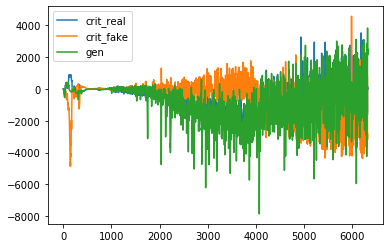

In [28]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
latent_dim = 100
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)

# train model
train(generator, critic, gan_model, data, latent_dim, n_epochs=10000)

In [29]:
noise = np.random.normal(0, 1, (100, latent_dim))
gen_imgs = generator.predict(noise)
gen_imgs = gen_imgs.reshape(100, 36)


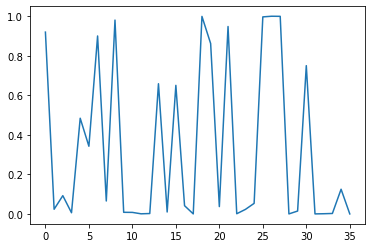

In [30]:
plt.plot(gen_imgs[0])

In [69]:
amat = squareform(np.array(gen_imgs[14]>0.4, dtype=int))

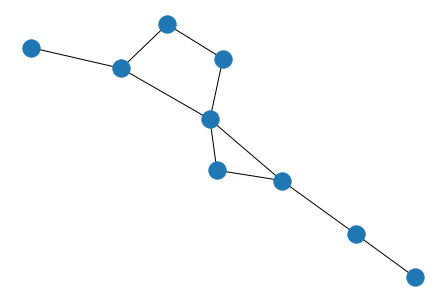

In [74]:
amat = squareform(np.array(gen_imgs[14]>0.1, dtype=int))
import networkx as nx
g = nx.from_numpy_array(amat)
nx.draw(g)

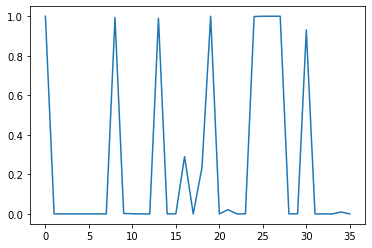

In [99]:
plt.plot(gen_imgs[11])

0 1
1 2
1 7
2 7
3 7
3 8
4 5
4 6
5 6


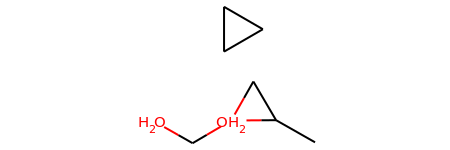

In [97]:
amat = squareform(np.array(gen_imgs[11]>0.34, dtype=int))
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol

atomicNumList=[6]*7+[8]*2
mol = get_proto_mol(atomicNumList)
eMol = Chem.EditableMol(mol)

bonds = np.triu(amat)
for j, k in zip(np.where(bonds)[0], np.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None
        
eMol.GetMol()

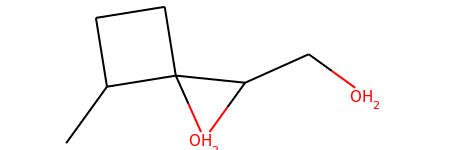

In [80]:
eMol.GetMol()